<a href="https://colab.research.google.com/github/rockaguirre/Neuro-140-Project/blob/main/neuro140_final_project_aguirre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import math
import pandas as pd
import seaborn as sns
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import *
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from PIL import Image, ImageEnhance

In [2]:
train_directory = '/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Training'
test_directory = '/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Testing'

In [3]:
classifications = ['notumor', 'glioma','meningioma', 'pituitary']

data_train = []
classifications_train = []

In [4]:
image_size = 128

for label in classifications:
  path = os.path.join(train_directory, label)
  names = os.listdir(path)
  for item in range(len(names)):
      image = cv2.imread(os.path.join(path, names[item]))
      image = cv2.resize(image, (image_size, image_size))
      data_train.append(image)
      classifications_train.append(label)

for label in classifications:
  path = os.path.join(test_directory, label)
  names = os.listdir(path)
  for item in range(len(names)):
      image = cv2.imread(os.path.join(path, names[item]))
      image = cv2.resize(image, (image_size, image_size))
      data_train.append(image)
      classifications_train.append(label)

data_train = np.array(data_train)
classifications_train = np.array(classifications_train)
data_test = np.array(data_train)
classifications_test = np.array(classifications_train)

In [5]:
data_train.shape

(7023, 128, 128, 3)

In [6]:
data_train, classifications_train = shuffle(data_train, classifications_train, random_state=30)

In [7]:
# ensure shape is the same
data_train.shape

(7023, 128, 128, 3)

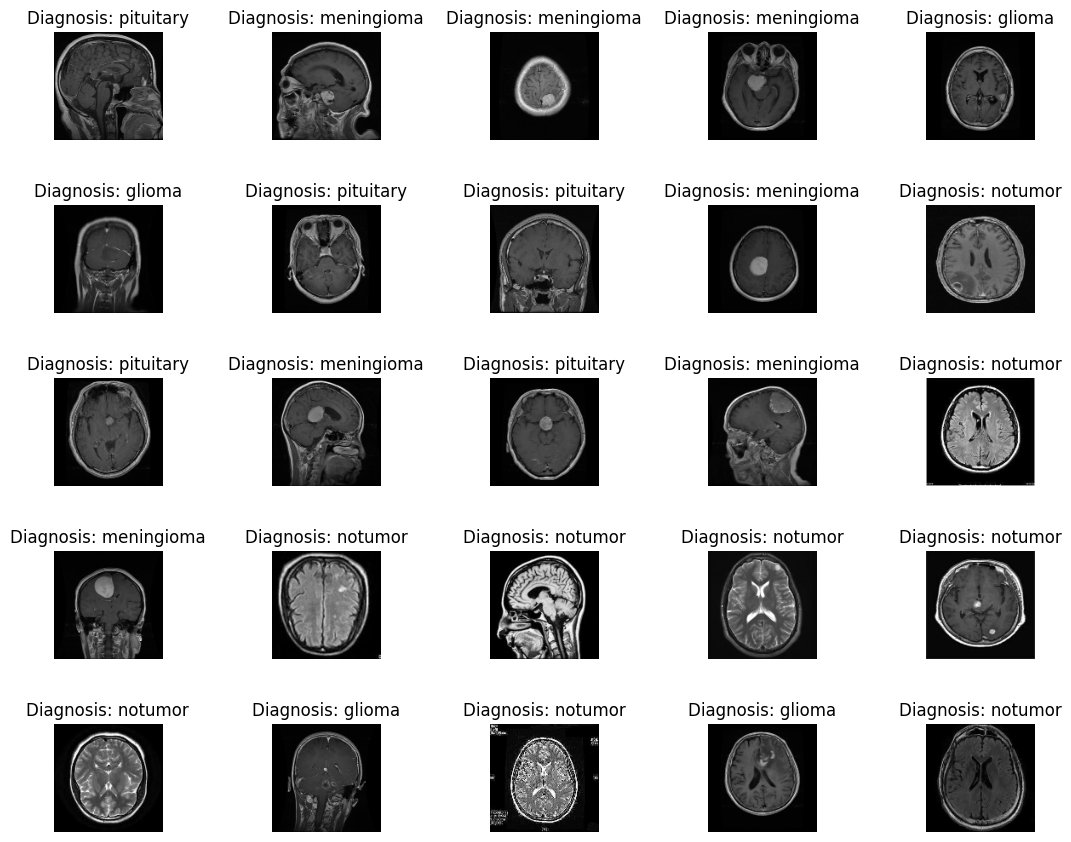

In [8]:
grid_width = 5
grid_height = 5

figure, axis = plt.subplots(grid_width, grid_height, figsize=(8,8))

img_idx = 0

for x in range(grid_width):
    for y in range(grid_height):
        axis[x][y].axis('off')
        axis[x][y].set_title('Diagnosis: '+ classifications_train[img_idx])
        axis[x][y].imshow(data_train[img_idx])
        img_idx += 1

# fix orientation and overlap of titles
plt.subplots_adjust(left=0, bottom=0, right=1.3, top=1, wspace=0.3, hspace=0.6)

In [9]:
# split dataset into train, test, and validation
data_train, data_test, classifications_train, classifications_test = train_test_split(data_train, classifications_train, test_size = 0.2, random_state=30)
data_train, data_validation, classifications_train, classifications_validation = train_test_split(data_train, classifications_train, test_size = 0.1, random_state=30)

In [10]:
classifications_train_updated = []
classifications_validation_updated = []
classifications_test_updated = []

# turn classifications like "glioma" into values
for label in classifications_train:
    classifications_train_updated.append(classifications.index(label))

# to_categorical to turn into a one hot encoded representation -- do not %100 understand but it helped fix a problem -- chatGPT told me to try
classifications_train = to_categorical(classifications_train_updated)

for label in classifications_validation:
    classifications_validation_updated.append(classifications.index(label))

classifications_validation = to_categorical(classifications_validation_updated)


for label in classifications_test:
    classifications_test_updated.append(classifications.index(label))

classifications_test = to_categorical(classifications_test_updated)


In [11]:
classifications_train

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
"""
def enhance_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image = np.array(image)/255.0

  return image
  """

In [ ]:
"""
unique_classification = os.listdir(train_directory)

def encode_classification(classifications):
  return np.array([unique_classification.index(x) for x in classifications])

def decode_classification(classifications):
  return np.array([unique_classification[x] for x in classifications])

def datagen(paths, classifications, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i, (path, classification) in enumerate(zip(paths, classifications)):
      if i % batch_size == 0:
          batch_images = transform_images(paths[i:i+batch_size])
          batch_classifications = encode_classification(classifications[i:i+batch_size])
          yield batch_images, batch_classifications
"""

In [ ]:
general_model = VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
# set beginning layers to non-trainable to retain pre-trained weights from imagenet

for layer in general_model.layers:
    layer.trainable=False

# set last block to trainable for new dataset
general_model.layers[-2].trainable=True
general_model.layers[-3].trainable=True
general_model.layers[-4].trainable=True

# first CNN model
first_model = Sequential()
first_model.add(Input(shape=(image_size,image_size,3)))
first_model.add(general_model)
first_model.add(Flatten())
first_model.add(Dropout(0.2))
first_model.add(Dense(units=128, activation='relu'))
first_model.add(Dropout(0.2))
first_model.add(Dense(units=4, activation='softmax'))

In [ ]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [ ]:
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
first_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics= 'Accuracy')

In [12]:
# scale data to match array type float32

scale_data_train = data_train.astype('float32')
scale_data_test = data_test.astype('float32')
scale_data_validation = data_validation.astype('float32')

scale_data_train /= 255
scale_data_test /= 255
scale_data_validation /= 255

In [ ]:
batch_size = 32
epochs = 10

history = first_model.fit(x=scale_data_train, y=classifications_train,
                          validation_data=(scale_data_validation, classifications_validation),
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1)

Epoch 1/10
158/158 [==============================] - 1285s 8s/step - loss: 1.1327 - Accuracy: 0.4709 - val_loss: 0.7755 - val_Accuracy: 0.6477
Epoch 2/10
158/158 [==============================] - 1270s 8s/step - loss: 0.6876 - Accuracy: 0.7075 - val_loss: 0.4311 - val_Accuracy: 0.8399
Epoch 3/10
158/158 [==============================] - 1252s 8s/step - loss: 0.4267 - Accuracy: 0.8418 - val_loss: 0.3292 - val_Accuracy: 0.8772
Epoch 4/10
158/158 [==============================] - 1221s 8s/step - loss: 0.3757 - Accuracy: 0.8566 - val_loss: 0.2485 - val_Accuracy: 0.9004
Epoch 5/10
158/158 [==============================] - 1260s 8s/step - loss: 0.2232 - Accuracy: 0.9197 - val_loss: 0.2463 - val_Accuracy: 0.9199
Epoch 6/10
158/158 [==============================] - 1250s 8s/step - loss: 0.2107 - Accuracy: 0.9203 - val_loss: 0.1945 - val_Accuracy: 0.9359
Epoch 7/10
158/158 [==============================] - 1255s 8s/step - loss: 0.1625 - Accuracy: 0.9399 - val_loss: 0.1751 - val_Accuracy:

In [ ]:
test_loss, test_accuracy = first_model.evaluate(datagen(test_path, test_classification, batch_size=batch_size))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

66/66 [==============================] - 373s 6s/step - loss: 0.4503 - sparse_categorical_accuracy: 0.9214
Test Loss: 0.45027217268943787
Test Accuracy: 0.9214340448379517


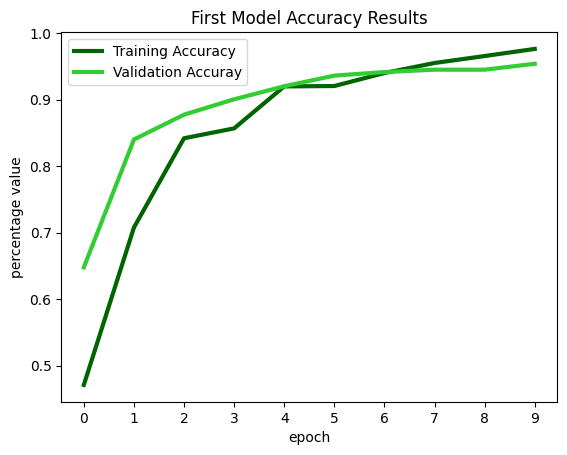

In [ ]:
plt.plot(history.history['Accuracy'], 'darkgreen', linewidth=3)
plt.plot(history.history['val_Accuracy'], 'limegreen', linewidth=3)
plt.title('VGG16 Model Accuracy Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Accuracy', 'Validation Accuray'], loc='upper left')
plt.show()

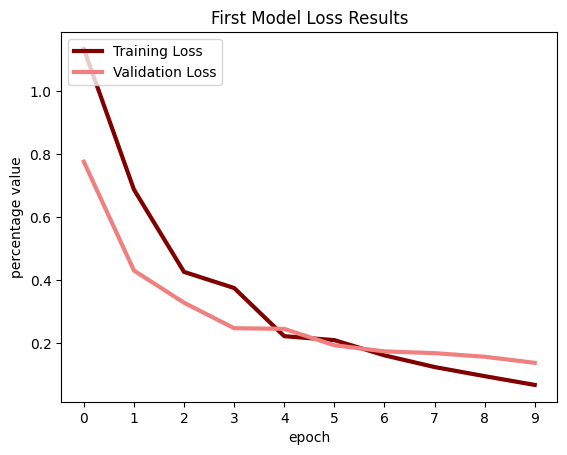

In [ ]:
plt.plot(history.history['loss'], 'maroon', linewidth=3)
plt.plot(history.history['val_loss'], 'lightcoral', linewidth=3)
plt.title('VGG16 Model Loss Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [13]:
second_general_model = ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
# set beginning layers to non-trainable to retain pre-trained weights from imagenet

for layer in second_general_model.layers:
    layer.trainable=False

# set last block to trainable for new dataset
second_general_model.layers[-2].trainable=True
second_general_model.layers[-3].trainable=True
second_general_model.layers[-4].trainable=True

# first CNN model
second_model = Sequential()
second_model.add(Input(shape=(image_size,image_size,3)))
second_model.add(second_general_model)
second_model.add(Flatten())
second_model.add(Dropout(0.2))
second_model.add(Dense(units=128, activation='relu'))
second_model.add(Dropout(0.2))
second_model.add(Dense(units=4, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [14]:
second_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='Accuracy')

In [15]:
batch_size = 32
epochs = 10
second_history = second_model.fit(x=scale_data_train, y=classifications_train,
                          validation_data=(scale_data_validation, classifications_validation),
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1)

Epoch 1/10
158/158 [==============================] - 361s 2s/step - loss: 0.9427 - Accuracy: 0.6557 - val_loss: 0.8619 - val_Accuracy: 0.6797
Epoch 2/10
158/158 [==============================] - 351s 2s/step - loss: 0.6801 - Accuracy: 0.7243 - val_loss: 0.7138 - val_Accuracy: 0.7224
Epoch 3/10
158/158 [==============================] - 350s 2s/step - loss: 0.5787 - Accuracy: 0.7528 - val_loss: 0.5412 - val_Accuracy: 0.7847
Epoch 4/10
158/158 [==============================] - 353s 2s/step - loss: 0.5559 - Accuracy: 0.7601 - val_loss: 0.4595 - val_Accuracy: 0.8185
Epoch 5/10
158/158 [==============================] - 351s 2s/step - loss: 0.5294 - Accuracy: 0.7775 - val_loss: 0.4898 - val_Accuracy: 0.7918
Epoch 6/10
158/158 [==============================] - 343s 2s/step - loss: 0.4811 - Accuracy: 0.8004 - val_loss: 0.8236 - val_Accuracy: 0.7313
Epoch 7/10
158/158 [==============================] - 350s 2s/step - loss: 0.4532 - Accuracy: 0.8131 - val_loss: 0.3829 - val_Accuracy: 0.8612

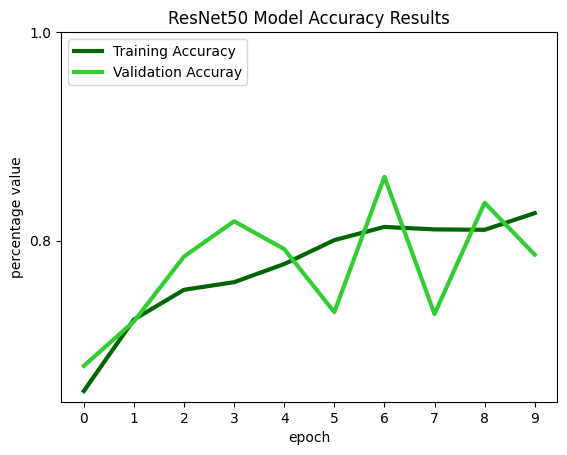

In [16]:
plt.plot(second_history.history['Accuracy'], 'darkgreen', linewidth=3)
plt.plot(second_history.history['val_Accuracy'], 'limegreen', linewidth=3)
plt.title('ResNet50 Model Accuracy Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.yticks([0.8,1])
plt.legend(['Training Accuracy', 'Validation Accuray'], loc='upper left')
plt.show()

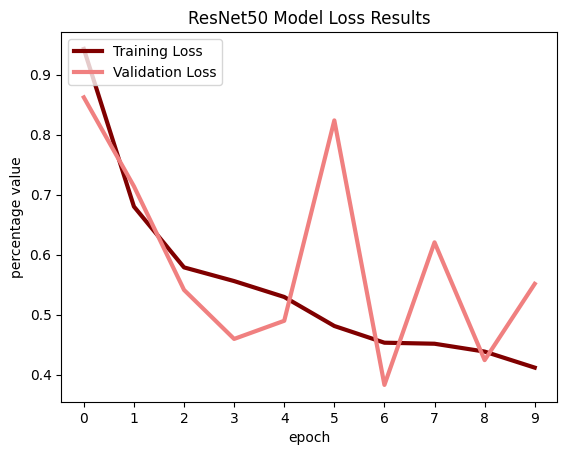

In [17]:
plt.plot(second_history.history['loss'], 'maroon', linewidth=3)
plt.plot(second_history.history['val_loss'], 'lightcoral', linewidth=3)
plt.title('ResNet50 Model Loss Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [21]:
third_model = Sequential()

third_model.add(Conv2D(filters=32, kernel_size = (3,3), activation='relu', input_shape = (image_size,image_size, 3)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(filters=64, kernel_size = (3,3), activation='relu', input_shape = (image_size,image_size,3)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(filters=128, kernel_size = (3,3), activation='relu', input_shape = (image_size,image_size,3)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Flatten())
third_model.add(Dense(512, activation='relu'))
third_model.add(Dense(4, activation='softmax'))

In [22]:
third_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics= 'Accuracy')

In [23]:
batch_size = 32
epochs = 10

third_history = third_model.fit(x=scale_data_train, y=classifications_train,
                          validation_data=(scale_data_validation, classifications_validation),
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1)

Epoch 1/10
158/158 [==============================] - 230s 1s/step - loss: 0.7267 - Accuracy: 0.7093 - val_loss: 0.3646 - val_Accuracy: 0.8594
Epoch 2/10
158/158 [==============================] - 227s 1s/step - loss: 0.3686 - Accuracy: 0.8568 - val_loss: 0.3183 - val_Accuracy: 0.9093
Epoch 3/10
158/158 [==============================] - 217s 1s/step - loss: 0.2351 - Accuracy: 0.9153 - val_loss: 0.2480 - val_Accuracy: 0.9093
Epoch 4/10
158/158 [==============================] - 224s 1s/step - loss: 0.1527 - Accuracy: 0.9432 - val_loss: 0.2021 - val_Accuracy: 0.9377
Epoch 5/10
158/158 [==============================] - 223s 1s/step - loss: 0.0897 - Accuracy: 0.9672 - val_loss: 0.1635 - val_Accuracy: 0.9448
Epoch 6/10
158/158 [==============================] - 231s 1s/step - loss: 0.0603 - Accuracy: 0.9818 - val_loss: 0.1464 - val_Accuracy: 0.9502
Epoch 7/10
158/158 [==============================] - 228s 1s/step - loss: 0.0233 - Accuracy: 0.9931 - val_loss: 0.1742 - val_Accuracy: 0.9555

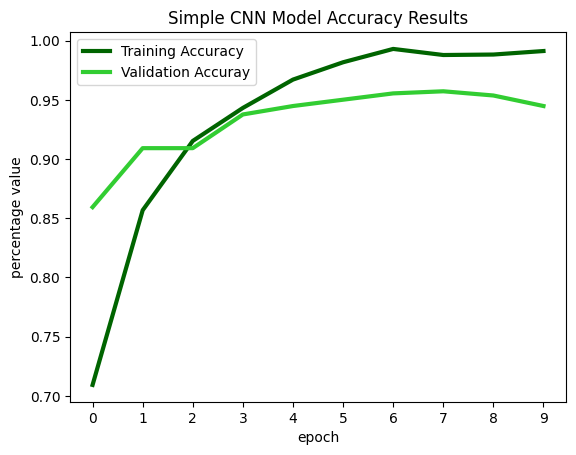

In [24]:
plt.plot(third_history.history['Accuracy'], 'darkgreen', linewidth=3)
plt.plot(third_history.history['val_Accuracy'], 'limegreen', linewidth=3)
plt.title('Simple CNN Model Accuracy Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Accuracy', 'Validation Accuray'], loc='upper left')
plt.show()

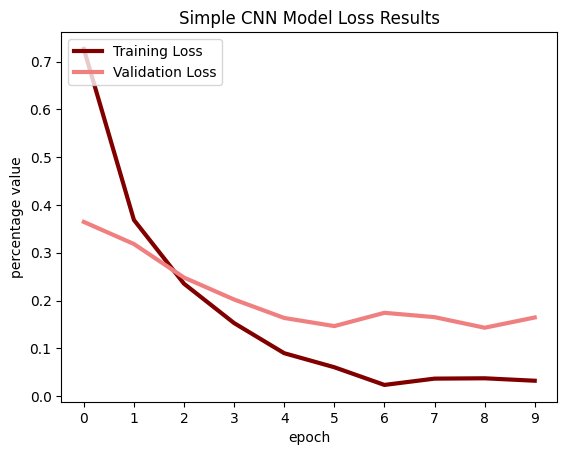

In [25]:
plt.plot(third_history.history['loss'], 'maroon', linewidth=3)
plt.plot(third_history.history['val_loss'], 'lightcoral', linewidth=3)
plt.title('Simple CNN Model Loss Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [35]:
predict_test = third_model.predict(scale_data_test)
predictions = np.argmax(predict_test, axis=1)
true_classification = np.argmax(classifications_test, axis=1)

print(classification_report(true_classification, predictions))

44/44 [==============================] - 15s 351ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       397
           1       0.99      0.83      0.90       341
           2       0.82      0.95      0.88       314
           3       0.96      0.98      0.97       353

    accuracy                           0.93      1405
   macro avg       0.94      0.93      0.93      1405
weighted avg       0.94      0.93      0.93      1405



In [37]:
print(type(confusion_matrix))

<class 'numpy.ndarray'>


In [41]:
!pip install --upgrade seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
print(sns.color_palette())

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


In [42]:
'''
confusion_matrix = confusion_matrix(true_classification,predictions)
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='b')
ax = sns.heatmap(confusion_matrix, cmap='mako', annot=True, fmt='d', xticklabels=classifications, yticklabels=classifications)
plt.title('Classification of Tumors from Brain MRI Scans')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show(ax)

'''

TypeError: ignored